# Reservoir OOIP Estimation

This notebook contains Data Analyses performed on the provided data sets, **LonghornReservoir.xlsx** and **Reservoir-Geometry.xlsx**. The objective is to create maps of the reservoir and measure OOIP using an analytical software language of choice, in this case, **Python 3.6**



<div class="alert alert-info">
<h4>Disclaimer</h4><p>This was a project for Reservoir Engineering 1 class at the <i>University of Texas at Austin</i>, taught by <b>Dr. Balhoff</b>. Initially completed in MATLAB, the authors implemented a Python version of the work for better visualization. This is a collaboration work done by <b>Eric Kim</b> and <b>Tyrel Khron</b></p>
</div>

# 0. Requirements

*The codes were developed on Windows 10, and were not tested on other machines.*

In [80]:
!pip install pandas==0.23.4 xlrd==1.1.0 matplotlib==3.0.0

# 1. Data Set Description
## 1.1 Reservoir Parameter Data

The provided spreadsheet **LonghornReservoir.xlsx** includes data for several important reservoir parameters for the *Longhorn Field* near *Plaquemines Parish, Louisiana*. Specifically, it includes several well locations (x, y positions) and the reservoir thickness, porosity, initial oil saturation, and initial pressure, at the location of each well. 

The grid blocks are regarded as uniform blocks with the size of 55 ft X 55 ft.

In [2]:
import pandas as pd

data = pd.read_excel('LonghornReservoir.xlsx', sheet_name='Sheet1')
print('\nInitial Oil Saturation:', 0.76)
data.iloc[:, :9].head()


Initial Oil Saturation: 0.76


,Well Name,Grid Block,Well-X (ft),Well-Y (ft),Time,Well Pressure (psi),Net Pay (ft),Porosity,Bo (RB/STB)
0,Duff_1,26 20,1402.5,1072.5,1959-05-01,3416.4,54.0,0.2475,1.170277
1,Duff_4,30 39,1622.5,2117.5,1959-05-01,3399.3,12.0,0.2455,1.170426
2,Duff_5,30 41,1622.5,2227.5,1959-05-01,3399.0,12.0,0.2557,1.170429
3,Duff_6,21 32,1127.5,1732.5,1959-05-01,3404.6,21.0,0.2796,1.170380
4,SL_2484_20,22 49,1182.5,2667.5,1959-05-01,3398.0,7.0,0.1876,1.170437


## 1.2 Reservoir Geometry Data

The provided spreadsheet **Reservoir-Geometry.xlsx** includes data for reservoir locations in the asset, in grid style. It's a binary data, in which 1 indicates the presence of reservoir, and 0, the other. 

In [3]:
# 106 x-grid and 69 y-grid blocks

reservoir_geometry = pd.read_excel('Reservoir-Geometry.xlsx', header=None)
reservoir_geometry.head()

,0,1,2,3,4,5,6,7,8,9,...,59,60,61,62,63,64,65,66,67,68
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,0,0,0,0


# 2. Processing Data for Calculation

The raw Pandas Dataframe data needs to be processed into an appropriate numpy array for future scientific calculation and visualization.

<div class="alert alert-info">
    <h4>Notes:</h4><p>Later the parameters in <i>&lt;class numpy.ndarray&gt;</i> will be converted to <i>&lt;class 'numpy.matrixlib.defmatrix.matrix'&gt;</i> to have dimension agreement for numpy matrix operation<br><br>Ex: <i>well_netpay = np.matrix(well_netpay)</i></p>
</div>

In [4]:
import numpy as np

# Reservoir parameter data transformation
well_x      = np.array(data['Well-X (ft)'])       # <class 'numpy.ndarray'>
well_y      = np.array(data['Well-Y (ft)'])
well_netpay = np.array(data['Net Pay (ft)'])
well_phi    = np.array(data['Porosity'])
well_Bo     = np.array(data['Bo (RB/STB)'])
num_well    = data.shape[0]                       # 38 Wells

# Reservoir geometry data transformation
reservoir_geometry = reservoir_geometry.values    # <class 'numpy.ndarray'>

# 3. Implementing Kriging Function
## 3.1 Background Information

In geostatistics, *Kriging* is an advanced geostatistical procedure that generates an estimated surface from a scattered set of points with z-values.

The system of Kriging equations can be written as the following matrix form: 

\begin{equation*}
[K][\lambda] = [M_2]
\end{equation*}

Where

\begin{equation*}
[K] = 
\begin{bmatrix}
C_{11} & C_{12} & C_{13} & C_{14} & 1 \\
C_{21} & C_{22} & C_{23} & C_{24} & 1 \\
C_{31} & C_{32} & C_{33} & C_{34} & 1 \\
C_{41} & C_{42} & C_{43} & C_{44} & 1 \\
1 & 1 & 1 & 1 & 0
\end{bmatrix}, \
[\lambda] = 
\begin{bmatrix}
\lambda_1 \\
\lambda_2 \\
\lambda_3 \\
\lambda_4 \\
-\mu
\end{bmatrix}, \
[M_2] = 
\begin{bmatrix}
C_{01} \\
C_{02} \\
C_{03} \\
C_{04} \\
1
\end{bmatrix}
\end{equation*}

The values $C_{nn}$ and $\lambda_{n}$ within the matrices can be obtained using the following equations:

&nbsp;&nbsp;1. $C_{11} = C_{22} = C_{33} C_{44} = c_{0} + c = nugget + sill$


&nbsp;&nbsp;2. $C(h) = C(0) - \gamma(h) = c_{0} + c - \gamma(h)$


&nbsp;&nbsp;3. $\gamma(h) \ = \left\{
                   \begin{array}{ll}
                        0, \ h \ = \ 0 \\
                        c \cdot [\frac{3}{2}\frac{h}{a}-\frac{1}{2}(\frac{h}{a})^2], \ h \ \leq \ a \\ 
                        c,  \ h \ \geq \ a \\
                    \end{array}
                \right.$


&nbsp;&nbsp;4. $
h \ = \ \sqrt{(x_1 \ - \ x_2)^2 + (y_1 \ - \ y_2)^2}
$

Where

&nbsp;&nbsp; nugget $(c_{0})$ = variance at zero distance

&nbsp;&nbsp; Range $(a)$ = the distance at which the semivariogram levels off and beyond which the semivariance is constant

&nbsp;&nbsp; Sill $(c)$ = the constant semivariance value beyond the range

## 3.2 Initialize Variables

In [13]:
# Grid Size - (ft)
dx = 55
dy = 55

# Number of grid blocks
num_grid_x = 106
num_grid_y = 69

# Variagram parameters
C0   = 2;     # Nugget 
a    = 2000   # Range 
sill = 20     # Sill

# Variogram Function - corresponds to 𝛾(h) 
def gamma_comp(C0, a, sill, h):
    if h == 0:
        y = 0
    elif h > a:
        y = C0 + sill
    else:
        y = C0 + sill * (1.5 * h / a - 0.5 * (h / a) ** 3)
    return y

## 3.3 Construct K-Matrix

In [14]:
# K-Matrix
K = np.zeros(shape=(num_well + 1, num_well + 1)) # K-matrix Initialization
for i in range(num_well - 1):
    for j in range(i + 1, num_well):
        h = np.sqrt( (well_x[i] - well_x[j])**2 + (well_y[i] - well_y[j])**2 ) # Distance between point-i to point-j
        K[i, j] = C0 + sill - gamma_comp(C0, a, sill, h)
        K[j, i] = K[i, j]        

# Declares values for the last column & last row of K-Matrix
for i in range(num_well):
    K[i, i] = C0 + sill
    K[i, num_well] = 1
    K[num_well, i] = 1

K[num_well, num_well] = 0

## 3.4 Create Meshgrid for Visualization

In [15]:
# Add dx at the upper limit to make it 1 X 106 array
X = np.arange(dx / float(2), num_grid_x * dx - dx / float(2) + dx, dx)
Y = np.arange(dy / float(2), num_grid_y * dy - dy / float(2) + dy, dy)
[x, y] = np.meshgrid(X, Y)

## 3.5 Solve for Lambda

In [16]:
# Matrix initialization
netpay = np.zeros(shape=(num_grid_y, num_grid_x))
phi    = np.zeros(shape=(num_grid_y, num_grid_x))
Bo     = np.zeros(shape=(num_grid_y, num_grid_x))
M2     = np.zeros(shape=(num_well + 1, 1))
M2[num_well, 0] = 1

for i in range(num_grid_y):
    for j in range(num_grid_x):
        if reservoir_geometry[j, i] == 1:
            for k in range(num_well):
                h = np.sqrt( (x[i, j] - well_x[k])**2 + (y[i, k] - well_y[k])**2 )
                
                # M2-Matrix
                M2[k, 0] = C0 + sill - gamma_comp(C0, a, sill, h)
            
            Lambda = np.linalg.solve(K, M2)
            
            # Numpy array needs to be converted into Numpy matrix.
            # Refer to the notes in section 2 of this Notebook
            netpay[i, j] = np.matrix(well_netpay) * Lambda[: -1]        
            phi[i, j]    = np.matrix(well_phi) * Lambda[: -1]             
            Bo[i, j]     = np.matrix(well_Bo) * Lambda[: -1]             
            
        else:
            netpay[i, j] = 0
            phi[i, j]    = 0
            Bo[i, j]     = 0           

## 3.5 Output

Initially 1-dimensional arrays of size (38,), the **Bo**, **Netpay**, and **Porosity** data are converted into 2-dimensional arrays of size (69, 106), by combining them with reservoir geometry data.

**The initial data**

In [17]:
data.iloc[:, [0, 1, 6, 7, 8]].head()

,Well Name,Grid Block,Net Pay (ft),Porosity,Bo (RB/STB)
0,Duff_1,26 20,54.0,0.2475,1.170277
1,Duff_4,30 39,12.0,0.2455,1.170426
2,Duff_5,30 41,12.0,0.2557,1.170429
3,Duff_6,21 32,21.0,0.2796,1.170380
4,SL_2484_20,22 49,7.0,0.1876,1.170437


**The transformed data - Bo, Netpay, Porosity (in order)**

In [18]:
pd.DataFrame(data=Bo).head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.169833,0.000000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.169809,1.169823,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.169786,1.169802,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.169763,1.169783,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.169744,1.169767,1.16979,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
pd.DataFrame(data=netpay).head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,38.983294,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.238446,39.092410,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.493520,39.297656,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.743008,39.492646,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39.977373,39.674529,39.403444,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
pd.DataFrame(data=phi).head()

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,104,105
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.286045,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.287276,0.286700,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.288501,0.287760,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.289608,0.288706,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.290453,0.289396,0.288391,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 4. Visualization
## 4.1 3-D Surface Plot

<IPython.core.display.Javascript object>


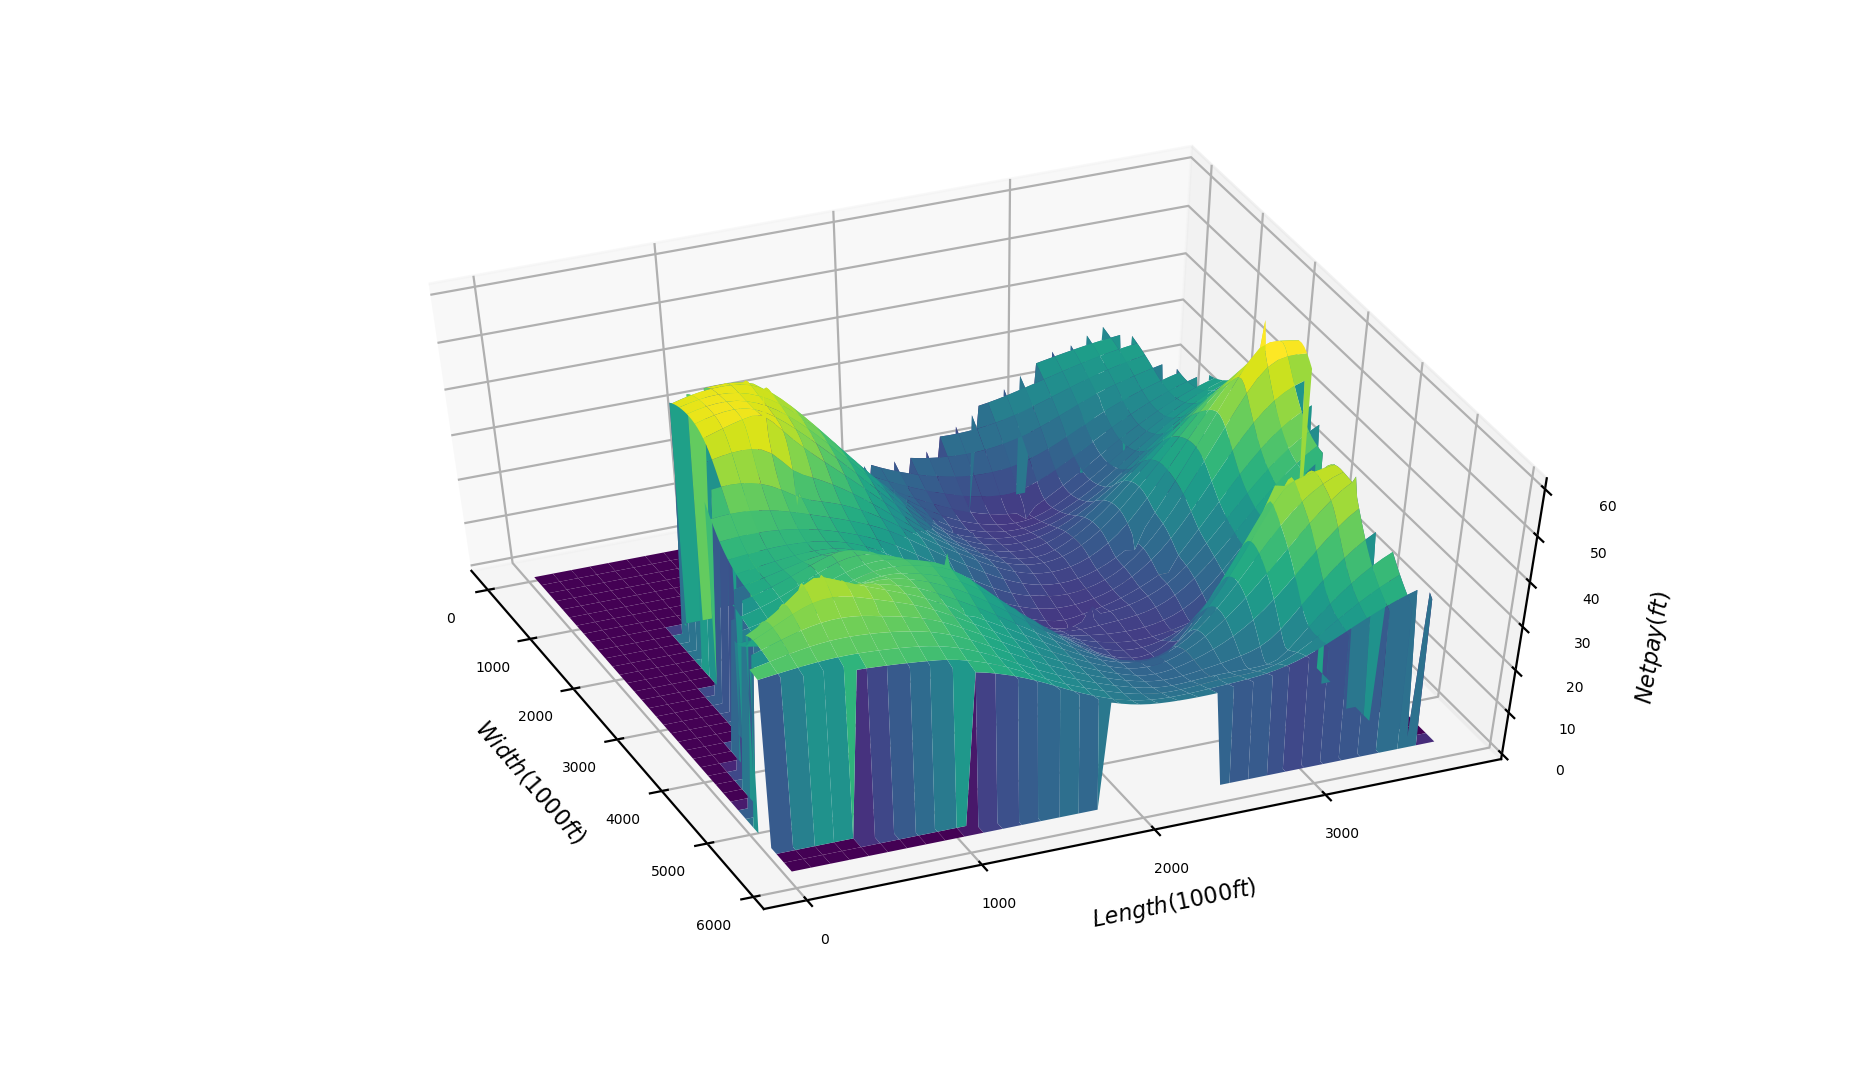

In [22]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import ticker
from matplotlib.ticker import FormatStrFormatter
from matplotlib import pyplot as plt
%matplotlib notebook

fig = plt.figure(figsize=(5, 4))
ax = fig.gca(projection='3d')

surf = ax.plot_surface(x, y, netpay, cmap='viridis', edgecolor='none')
ax.set_xlabel('$Width (1000 ft)$', fontsize=8)
ax.set_ylabel('$Length (1000 ft)$', fontsize=8)
ax.set_zlabel('$Netpay (ft)$', fontsize=8)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1000))

ax.xaxis.set_tick_params(labelsize=5)
ax.yaxis.set_tick_params(labelsize=5)
ax.zaxis.set_tick_params(labelsize=5)

## 4.2 Reservoir Netpay Contour Plot

<IPython.core.display.Javascript object>


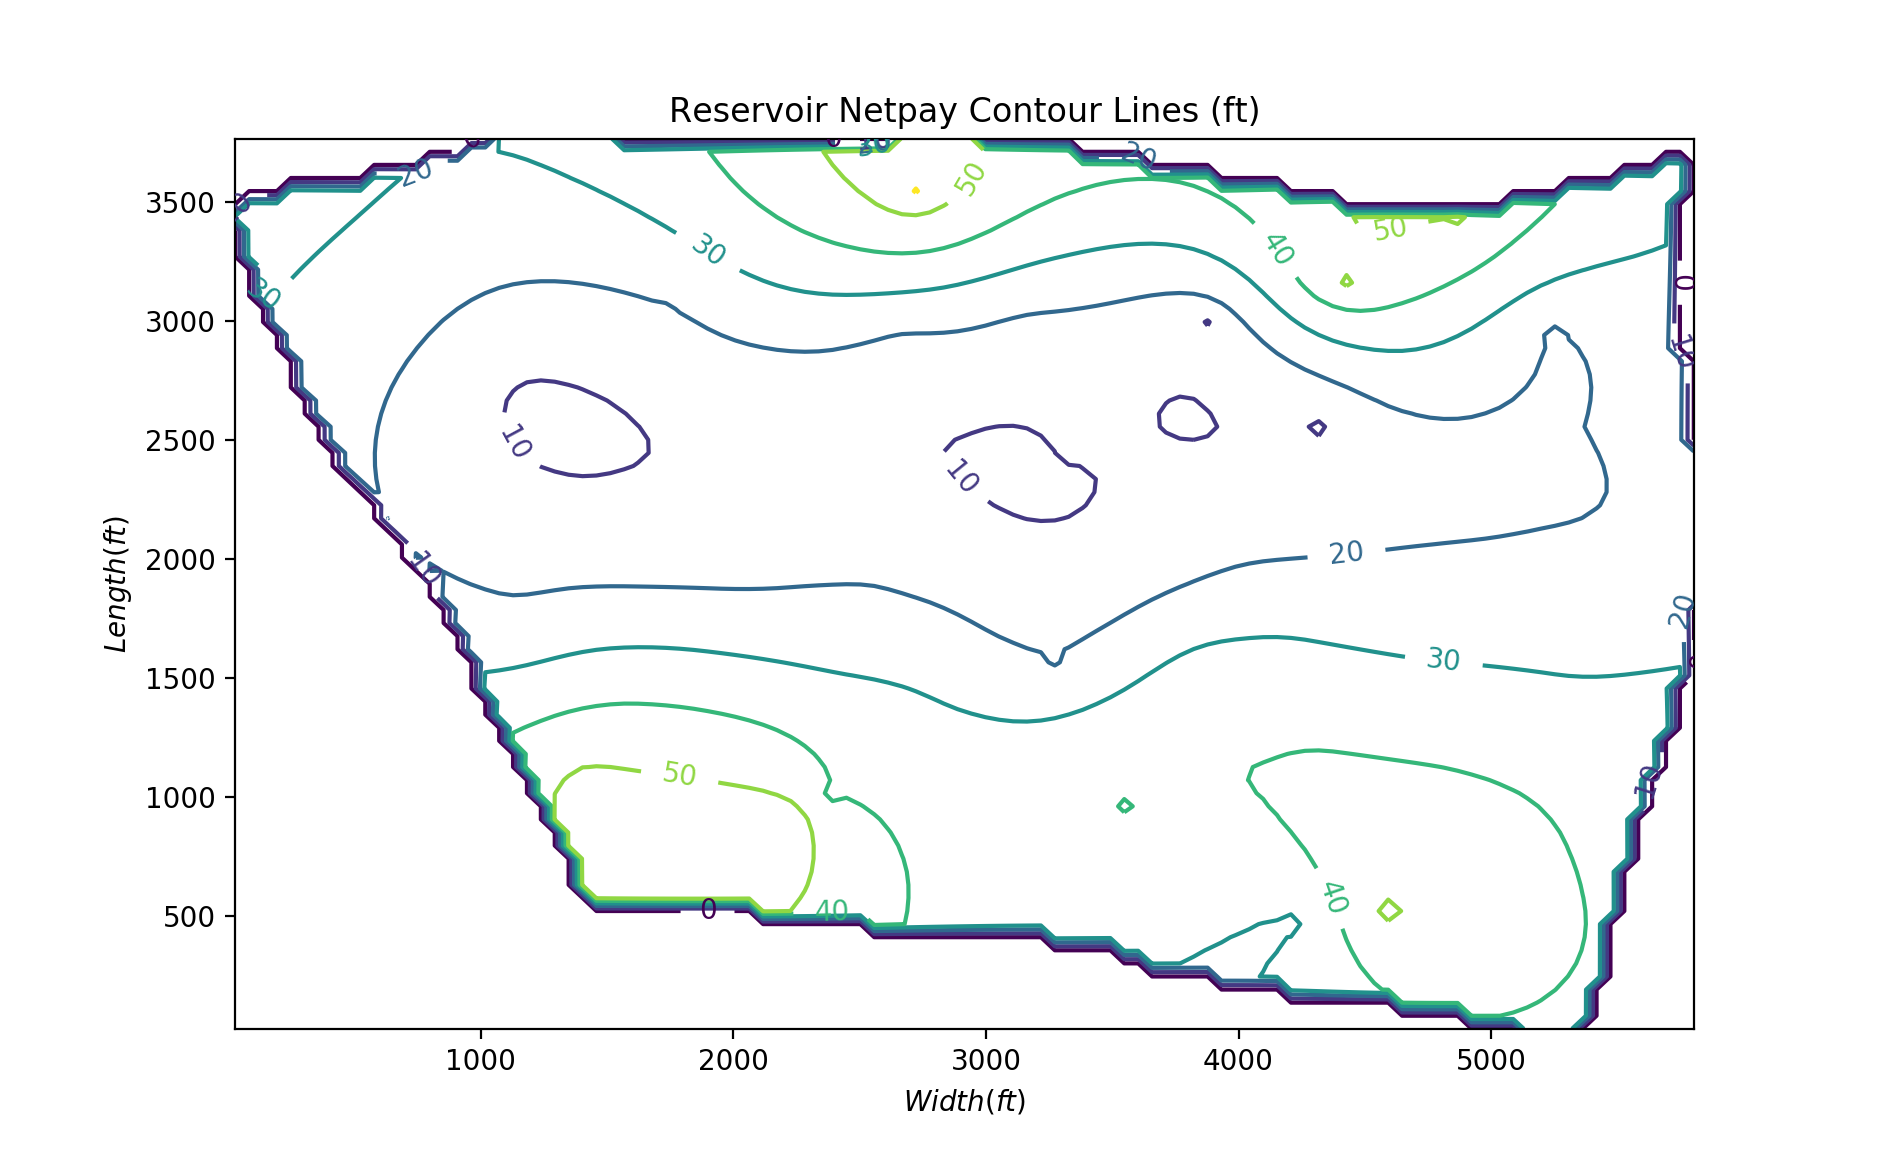

<a list of 27 text.Text objects>

In [23]:
fig, ax = plt.subplots()
contours = ax.contour(x, y, netpay, levels=[0, 10, 20, 30, 40, 50, 60])

ax.set_title('Reservoir Netpay Contour Lines (ft)')
ax.set_xlabel('$Width (ft)$')
ax.set_ylabel('$Length (ft)$')

plt.clabel(contours, inline=1, fontsize=10, fmt='%1.0f')

## 4.3 OOIP Contour Plot

OOIP (Original Oil In Place) contour plot will be generated using the following equation:

\begin{equation*}
OOIP = (h \ \times \ \Phi \ \times \ S_o) \ / \ B_o
\end{equation*}

Where 

&nbsp;&nbsp; $h$ = netpay height (ft)

&nbsp;&nbsp; $\Phi$ = porosity

&nbsp;&nbsp; $S_o$ = oil saturation 

&nbsp;&nbsp; $B_o$ = oil formation volume factor (RB / STB)

<IPython.core.display.Javascript object>


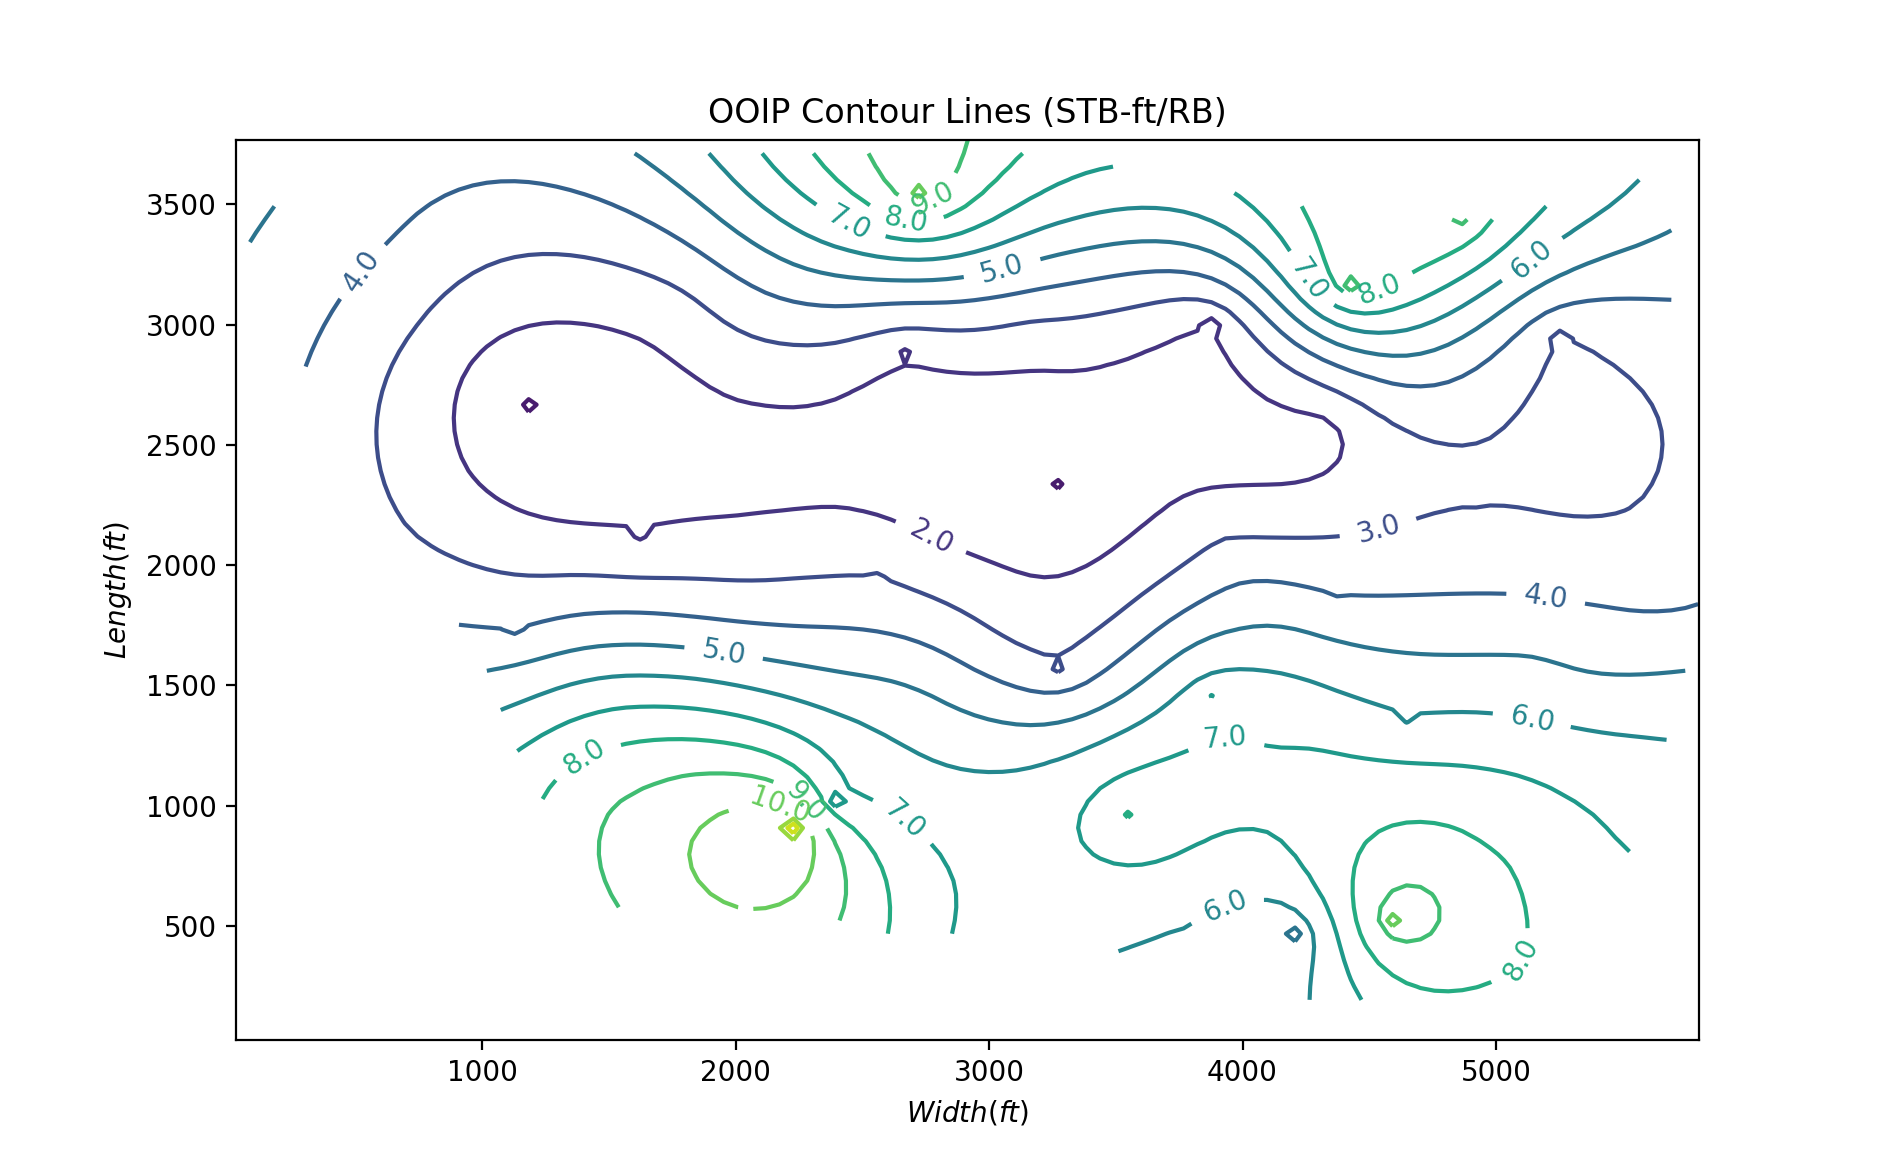

c:\users\erickim\.conda\envs\pge\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


<a list of 20 text.Text objects>

In [24]:
fig, ax = plt.subplots()

# The initial oil saturation is 0.76, from "LonghornReservoir.xlsx". Refer to section 1.1 of this Notebook
contours=plt.contour(x, y, 0.76 * phi * netpay / Bo, 12)

ax.set_title("OOIP Contour Lines (STB-ft/RB)")
ax.set_xlabel('$Width (ft)$')
ax.set_ylabel('$Length (ft)$')

plt.clabel(contours, inline=1, inline_spacing=1, fontsize=10, fmt='%1.1f')

# 5. Analysis
## 5.1 Net Pay Area Calculation

The netpay area within all contour intervals can be calculated.

After applying the Kriging function, the Numpy object, **netpay**, is a 2-D 106 X 69 matrix, with each point representing a grid block of 55 X 55 ft in area. A simple *for-loop* can be constructed to to calculate the total netpay area for a given netpay interval.

In [25]:
netpay_area = [0 for i in range(7)]
netpay_intervals = ['0 ft - 10 ft', '10 ft - 20 ft', '20 ft - 30 ft', '30 ft - 40 ft', 
                    '40 ft - 50 ft', '50 ft - 60 ft', '60 ft - 70 ft']

for i in range(num_grid_y):
    for j in range(num_grid_x):
        if netpay[i, j] > 70:
            pass
        if netpay[i, j] > 60:
            netpay_area[0] += 55 * 55
        elif netpay[i, j] > 50:
            netpay_area[1] += 55 * 55            
        elif netpay[i, j] > 40:
            netpay_area[2] += 55 * 55
        elif netpay[i, j] > 30:
            netpay_area[3] += 55 * 55
        elif netpay[i, j] > 20:
            netpay_area[4] += 55 * 55  
        elif netpay[i, j] > 10:
            netpay_area[5] += 55 * 55
        elif netpay[i, j] > 0:
            netpay_area[6] += 55 * 55
        else:
            pass

pd.DataFrame(data=[netpay_intervals, sorted(netpay_area, reverse=True)], index=['Net Pay', 'Area (ft^2)']).T

,Net Pay,Area (ft^2)
0,0 ft - 10 ft,4576825
1,10 ft - 20 ft,4467925
2,20 ft - 30 ft,4204750
3,30 ft - 40 ft,2271775
4,40 ft - 50 ft,692725
5,50 ft - 60 ft,375100
6,60 ft - 70 ft,3025


## 5.2 OOIP Calculation
The OOIP (Original Oil In Place) within all contour intervals can be calculated, in the same way as *Net Pay Area Calculation*.


In [79]:
OOIP = 0.76 * netpay * phi / Bo
netpay_area = [0 for i in range(13)]
netpay_intervals = ['0~1', '1~2', '2~3', '3~4', '4~5', '5~6', '6~7', '7~8', '8~9', '9~10', '10~11', '11~12', '12~13']
num_interval = len(netpay_intervals)
grid_block_area = 55 * 55 # 55ft X 55ft

for i in range(num_grid_y):
    for j in range(num_grid_x):
        if OOIP[i, j] > 13:
            pass
        elif OOIP[i, j] > 12:
            netpay_area[0] += 55 * 55
        elif OOIP[i, j] > 11:
            netpay_area[1] += 55 * 55
        elif OOIP[i, j] > 10:
            netpay_area[2] += 55 * 55
        elif OOIP[i, j] > 9:
            netpay_area[3] += 55 * 55
        elif OOIP[i, j] > 8:
            netpay_area[4] += 55 * 55
        elif OOIP[i, j] > 7:
            netpay_area[5] += 55 * 55
        elif OOIP[i, j] > 6:
            netpay_area[6] += 55 * 55
        elif OOIP[i, j] > 5:
            netpay_area[7] += 55 * 55
        elif OOIP[i, j] > 4:
            netpay_area[8] += 55 * 55
        elif OOIP[i, j] > 3:
            netpay_area[9] += 55 * 55
        elif OOIP[i, j] > 2:
            netpay_area[10] += 55 * 55
        elif OOIP[i, j] > 1:
            netpay_area[11] += 55 * 55
        elif OOIP[i, j] > 0:
            netpay_area[12] += 55 * 55
        else:
            pass

#####################################################################################
#
# Scalable version of the above code, in case we have too many intervals:
#
# temp = [0 for i in range(num_interval)]
# for i in range(num_grid_y):
#     for j in range(num_grid_x):
#         counter = num_interval + 1
#         for k in range(num_interval):
#             if OOIP[i, j] > num_interval - k and OOIP[i, j] < num_interval - k + 1:
#                 temp[k] += grid_block_area
#             counter -= 1
#
######################################################################################

pd.DataFrame(data=[netpay_intervals, sorted(netpay_area, reverse=True)], index=['OOIP (STB / ft^2) ', 'Area (ft^2)']).T

c:\users\erickim\.conda\envs\pge\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


,OOIP (STB / ft^2),Area (ft^2)
0,0~1,2601500
1,1~2,2565200
2,2~3,2196150
3,3~4,2126575
4,4~5,1981375
5,5~6,1833150
6,6~7,1712150
7,7~8,946825
8,8~9,447700
9,9~10,172425


## 5.3 Total Reservoir OOIP

Total reservoir OOIP can be calculated by summing up the multiples of *OOIP (STB / ft^2)* and *Area (ft^2)*.

For calculation purpose, the median value of each OOIP interval is used.

In [81]:
avg_OOIP_intervals = [0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, 10.5, 11.5, 12.5]

total_OOIP = np.sum(np.multiply(avg_OOIP_intervals, netpay_area))
total_OOIP

136828312.5

> Total OOIP = 136.8 Mbbls